<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Algoritmos_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Gillespie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Método de siguiente reacción sin redes

In [ ]:
def Gillespie_First_Reaction(N,X_S,X_I,beta,gamma,T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    Historia=[[0,X_S,X_I]]
    while(flag):
        tau=np.random.exponential(1/((beta/N)*X_S*X_I+gamma*X_I))
        p=np.random.uniform(0,1)
        if(p<(beta*X_S/N)/((beta/N)*X_S+gamma)):#Infeccion
            X_S+=-1
            X_I+=1
        else:
            X_I-=1
        t+=tau
        Historia.append([t,X_S,X_I])
        if(X_S==0 or X_I==0 or t>T):
            flag=False
    return Historia

### Ejemplo

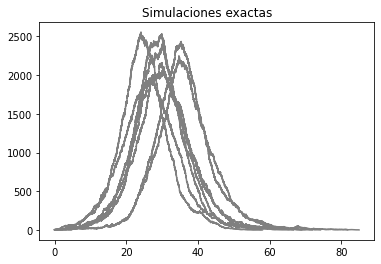

In [ ]:
N=10**5
S_0=N-2
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    while(len(H)<10):
        H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR markoviano en redes

In [2]:
import networkx as nx

In [3]:
N=10**3
G=nx.random_degree_sequence_graph(np.random.poisson(10,size=N))

In [4]:
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)

In [22]:
X_I_indexes
X_I=len(X_I_indexes)

In [6]:
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

In [8]:
G.has_edge(0,1)

False

In [63]:
G.nodes[0]['Estado:']

'Susceptible'

In [9]:
num_cont_inf_por_indice=np.zeros(N)
for i in range(N):
    for j in X_I_indexes:
        if (G.has_edge(i,j)):
            num_cont_inf_por_indice[i]+=1

In [23]:
#num_cont_inf_por_indice

True

In [26]:
#Sabemos que el rango de K (el número de contactos infecciosos de un susceptible al tiempo $t$) está acotado por I(t):
#Generamos la partición(Del conjunto de susceptibles en riesgo). Orden O(K*N)
P=[]
for k in range(int(X_I)):
    P.append([i for i, j in enumerate(num_cont_inf_por_indice) if j == k])
#P[i] es el conjunto de indices de individuos que tienen exactamente $i$ contactos infecciosos.
#Esto se puede mejorar, no me interesa saber quiénes son, sólo cuántos (por ahora).

In [32]:
Lambda=0
beta=1.25
gamma=1
Lambdas=[]
for k in range(len(P)):
    Lambdas.append(beta*len(P[k])*k)
    Lambda+=Lambdas[-1]
Lambdas.append(gamma*X_I)
Lambda+=Lambdas[-1]

In [15]:
def Monte_Carlo_Step_exp(Lambdas,num_cont_inf_por_indice,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)#Tiempo de siguiente reacción, hasta ahora desconocida.
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            k+=1
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
        #k es el número de contactos infecciosos del seleccionado.
        #Seleccionamos uno aleatoriamente de ese grupo
        new_reaction=np.random.choice([i for i, j in enumerate(num_cont_inf_por_indice) if j == k])
    else:
        #Seleccionar un infeccioso al azar.
        new_reaction=np.random.choice(X_I_indexes)
    return tau,new_reaction
#Monte_Carlo_Step_exp(Lambdas)

In [16]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]#Focus
    while(flag):
        #Generar las Lambdas------------------
        num_cont_inf_por_indice=np.zeros(N)
        for i in range(N):
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j) and G_network_initial.nodes[i]['Estado:']=='Susceptible'):
                    num_cont_inf_por_indice[i]+=1
        #Sabemos que el rango de K (el número de contactos infecciosos de un susceptible al tiempo $t$) está acotado por I(t):
        #Generamos la partición(Del conjunto de susceptibles en riesgo). Orden O(K*N)
        P=[]
        for k in range(int(X_I)):
            P.append([i for i, j in enumerate(num_cont_inf_por_indice) if j == k])
        #P[i] es el conjunto de indices de individuos que tienen exactamente $i$ contactos infecciosos.
        #Esto se puede mejorar, no me interesa saber quiénes son, sólo cuántos (por ahora).
        Lambda=0
        Lambdas=[]
        for k in range(len(P)):
            Lambdas.append(beta*len(P[k])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction=Monte_Carlo_Step_exp(Lambdas,num_cont_inf_por_indice,X_I_indexes)
        print("tiempo generado",tau,new_reaction)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'
            X_I_indexes=np.append(X_I_indexes,new_reaction)
            print('Infeccion actualizada')
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            X_I_indexes=np.delete(X_I_indexes,np.where(X_I_indexes == new_reaction))
            print('Recuperacion actualizada')
        t+=tau
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia
        #-------------------------------------------

### Ejemplo

In [10]:
N=10**2
G=nx.random_degree_sequence_graph(np.random.poisson(10,size=N))
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

In [17]:
H=Gillespie_Direct_Method_Network(beta=1.25,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G,T=np.inf)

tiempo generado 0.0003589354858512596 85
Infeccion actualizada
tiempo generado 0.0018793850069755075 9
Infeccion actualizada
tiempo generado 0.01582804734403143 87
Infeccion actualizada
tiempo generado 0.030404676773571376 75
Recuperacion actualizada
tiempo generado 0.04107373527149124 72
Infeccion actualizada
tiempo generado 0.015320303805112024 62
Infeccion actualizada
tiempo generado 0.010209584350168818 57
Infeccion actualizada
tiempo generado 0.011616760350644056 10
Infeccion actualizada
tiempo generado 0.002763487705579147 34
Infeccion actualizada
tiempo generado 0.009095167135234648 12
Infeccion actualizada
tiempo generado 0.014780748885705262 37
Infeccion actualizada
tiempo generado 0.003997909542319547 96
Infeccion actualizada
tiempo generado 0.014722968754899661 92
Infeccion actualizada
tiempo generado 0.004844946111806728 45
Infeccion actualizada
tiempo generado 0.005583250739065913 84
Infeccion actualizada
tiempo generado 0.001977669480807793 36
Infeccion actualizada
tiempo

In [93]:
H

[[0, 995, 5], [0.007669482187925033, 994, 6]]

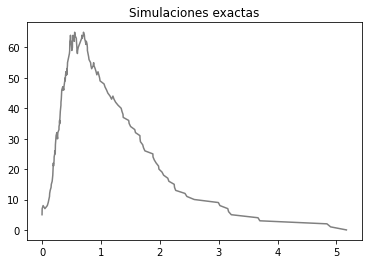

In [18]:
H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR no-markoviano.



## Método directo para SIR no-markoviano en redes